# Appendix B. Quaternion Kinematics and Differential Equations
<sub><sup>*Contributors: Mark E. Petersen*</sup></sub>
### Table Of Contents
1. [Introduction](#Introduction)
1. [Motivating Example](#Motivating-Example)
    1. [Group Representation Class](#Group-Representation-Class)
    1. [Visualize Class](#Visualize-Class)
    1. [Kinematics](#Kinematics)
1. [Naive Integration Methods](#Naive-Integration-Methods)
    1. [Euler's Method](#Euler's-Method)
    1. [Runge-Kutta 4 (RK4) ](#Runge-Kutta-4-%28RK4%29)
1. [Integrating on the Manifold](#Integrating-on-the-Manifold)

## Introduction

This appendix continues the discussion of using the unit quaternion to represent attitude which was introduced in [Appendix-A](A-Attitude-Representations.ipynb). In this notebook, we will derive and discuss the unit quaternion kinematics to describe and object's rotation. Using these kinematics, we can solve differential equation to express an object's rotation as a function of time. The attitude kinematics can be propagated on and off the manifold using different techniques such as Euler Integration, Runge-Kutta (RK4) Integration, and integrating directly on the manifold. 

This appendix follows the outline shown in [Solving Differential Equations](/notebooks/Unit-1-SO2/1.3-Solving-Differential-Equations.ipynb) and it will extend the motivating example to SO(3) using the unit quaternion lie group. 

## Motivating Example
Before we considered a pencil spinning on a flat table with configuration in space $S^1$. We extend the example by considering a pencil of unit lengh that can spin freely in space without any translation. The pencil's angular velocity is given by the column vector $\omega = \left[\phi,\theta,\psi \right]^T$, which is being measured at a sampling rate of $Ts = 0.01$ seconds. 

Let's first generate samples from the gyro on our spinning pencil. We assume that the pencil starts with some initial velocity that slowly decays over time.

<IPython.core.display.Javascript object>


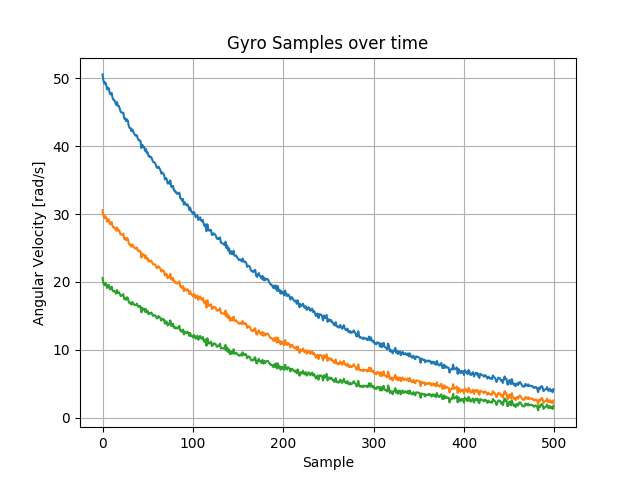

In [7]:
%matplotlib notebook
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

def generate_gyro_samples(w0=np.array([[50],[30],[20]]), Ts=0.01, secs=5, alpha=0.5, sigma=0.25):
    
    # Number of samples
    N = np.int(secs/Ts)

    # Sample time vector
    n=np.arange(N)

    # Generate the slowly-decaying signal
    w=np.multiply(w0,np.exp(-alpha*n*Ts))

    # Make some noise!
    eta = sigma*np.random.randn(N)

    d = {'w':w+eta, 'Ts':Ts, 'secs':secs, 'alpha':alpha, 'sigma':sigma}

    return d

samples = generate_gyro_samples()
w = samples['w']
fig = plt.figure()
plt.plot(w.transpose())
plt.title('Gyro Samples over time')
plt.grid();plt.xlabel('Sample'); plt.ylabel('Angular Velocity [rad/s]')
plt.show()

### Group Representation Class
We will use the unit quaternion to represent the orientation of the pencil in $S^3$. To do this, the following class is used whose methods were constructed based on the dicussuion in [Appendix-A](A-Attitude-Representations.ipynb)

In [8]:
import numpy as np 


class Quaternion:

    # Constructs the quaternion q = [w,x,y,z] where
    # w is the scalar and x,y,z form the vector.
    def __init__(self, *args):

        self._w, self._x, self._y, self._z = 1,0,0,0

        if len(args) == 0: # init identity quaternion
            self.init_quaternion(1,0,0,0)
        elif len(args) == 1: # init quaternion from rotation matrix
            self.r_to_q(args[0])
        elif len(args) == 2: # init quaternion from axel angel
            self.aa_to_q(args[0],args[1]) 
        elif len(args) == 3: # init quaternion from euler angles 
            self.euler_to_q(args[0],args[1],args[2])
        elif len(args) == 4: # init quaternion from scalar and vector
            self.init_quaternion(args[0],args[1],args[2],args[3])
        else:
            print('Input argument not understood. Using default')
            self.init_quaternion([1,0,0,0])



    # Basic quaternion constructor
    def init_quaternion(self, w, x, y, z):
        self._w = w     
        self._x = x     
        self._y = y     
        self._z = z  



    # Converts the rotation matrix to quaternion. 
    def r_to_q(self, R = np.identity(3)):
        self._w = 0.5*np.sqrt(1+np.float(R.trace()))
        self._x = 0.5*np.sqrt(1+R[0,0]-R[1,1]-R[2,2])
        self._y = 0.5*np.sqrt(1-R[0,0]+R[1,1]-R[2,2])
        self._z = 0.5*np.sqrt(1-R[0,0]-R[1,1]+R[2,2])



    # Converts quaternion to rotation matrix
    def q_to_r(self):

        r11 = self._w**2+self._x**2-self._y**2-self._z**2
        r12 = 2*(self._x*self._y + self._w*self._z)
        r13 = 2*(self._x*self._z - self._w*self._y)

        r21 = 2*(self._x*self._y - self._w*self._z)
        r22 = self._w**2-self._x**2+self._y**2-self._z**2
        r23 = 2*(self._y*self._z + self._w*self._x)

        r31 = 2*(self._x*self._z + self._w*self._y)
        r32 = 2*(self._y*self._z - self._w*self._x)
        r33 = self._w**2-self._x**2-self._y**2+self._z**2

        R = np.matrix([[r11,r12,r13], \
                      [r21,r22,r23], \
                      [r31,r32,r33]])

        return R



    # Converts angle axis to quaternion.
    # - theta is the angle of rotation in radians
    # - n is the axes about rotation 
    def aa_to_q(self, theta=0, n=np.array([0,0,0])):
        self._w = np.cos(theta/2)
        self._x = np.sin(theta/2)*n[0]
        self._y = np.sin(theta/2)*n[1]
        self._z = np.sin(theta/2)*n[2]



    # Converts quaternion to angle axis
    def q_to_aa(self):

        theta = 2*np.arcsin(np.sqrt(self._x**2+self._y**2+self._z**2))

        # There is no rotation, return identity element ?????
        if np.round(theta,4) == 0:
            theta = 0
            n1,n2,n3 = 0,0,0
        # There is rotation, compute vector elements
        else:
            n1 = self._x/np.sin(theta/2)
            n2 = self._y/np.sin(theta/2)
            n3 = self._z/np.sin(theta/2)

        return theta, np.array([n1,n2,n3])



    # Converts 321 sequence of euler angles to quaternion
    def euler_to_q(self, phi=0, theta=0, psi=0):
        c_psi,c_th,c_phi,s_psi,s_th,s_phi = np.cos(psi/2),np.cos(theta/2),np.cos(phi/2),np.sin(psi/2),np.sin(theta/2),np.sin(phi/2)
        self._w = c_psi*c_th*c_phi + s_psi*s_th*s_phi
        self._x = c_psi*c_th*s_phi - s_psi*s_th*c_phi
        self._y = c_psi*s_th*c_phi + s_psi*c_th*s_phi
        self._z = s_psi*c_th*c_phi - c_psi*s_th*s_phi



    # Returns the 321 sequence of euler angels
    def q_to_euler(self):
        theta = np.arcsin(2*(self._w*self._y-self._z*self._x))
        if (np.round(np.cos(theta),4) != 0):
            phi = np.arctan2(self._x+self._z,self._w-self._y) + np.arctan2(self._x-self._z,self._w+self._y)
            psi = np.arctan2(self._x+self._z,self._w-self._y) - np.arctan2(self._x-self._z,self._w+self._y)
        else:
            psi = 0
            if np.round(theta,4) == np.round(np.pi/2,4):
                phi = np.arctan2(self._x-self._z,self._w-self._y)
            else:
                phi = np.arctan2(self._x+self._z,self._w+self._y)
        return phi,theta,psi



    # Sets the quaternion to another quaternion
    def equal(self,q):
        self._w, self._x, self._y, self._z = q._w, q._x, q._y, q._z



    # Returns a copy of itself
    def copy(self):
        q = Quaternion()
        q.equal(self)
        return q



    # Returns the identity group element of the quaternion
    @staticmethod
    def identity():
        return Quaternion(1,0,0,0)



    # Overrides the addition operation
    def __add__(self,other):
        if other.__class__.__name__ == self.__class__.__name__:
            q = Quaternion(self._w+other._w, self._x+other._x, self._y+other._y, self._z+other._z)
        else:
            print("Only can do addition with type: "+self.__class__.__name__)
            q = Quaternion()
        return q



    # Implements quaternion division by a scalar
    def __div__(self,other):
        if np.isscalar(other):
            return self.scalar_mult(self,1.0/other)
        else:
            print("Only can do division with scalar")



    # Overrides the multiplication operation
    def __mul__(self,other):
        if other.__class__.__name__ == self.__class__.__name__:
            return self.quaternion_mult(self, other)
        elif isinstance(other,np.ndarray):
            return self.vector_rot(self,other)
        elif np.isscalar(other):
            return self.scalar_mult(self,other)
        else:
            print("Multiplication with type: "+ type(other).__name__ +" not implemented.")


        

    # Implements quaternion multiplication by a scalar
    @staticmethod
    def scalar_mult(q,s):
        return Quaternion(q._w*s,q._x*s,q._y*s,q._z*s)



    # Multiplies two quaternions together q1*q2
    @staticmethod
    def quaternion_mult(q2,q1):
        # q2.p()
        n_prime = q2.mat()
        n = np.matrix([[q1._x],[q1._y],[q1._z],[q1._w]])
        n_dprime = n_prime*n
        return Quaternion(n_dprime[3,0],n_dprime[0,0],n_dprime[1,0],n_dprime[2,0])



    # Rotates a vector by the quaternion
    @staticmethod
    def vector_rot(q,v):
        V = Quaternion(0,v[0,0],v[1,0],v[2,0]) # convert vector to quaternion
        V_prime = q*V*q.inv()
        return np.array([[V_prime._x],[V_prime._y],[V_prime._z]])



    # Converts the quaternion into matrix representation
    def mat(self):
        return np.matrix([[ self._w,  self._z, -self._y, self._x],
                          [-self._z,  self._w,  self._x, self._y],
                          [ self._y, -self._x,  self._w, self._z],
                          [-self._x, -self._y, -self._z, self._w]])



    # Returns the inverse of the quaternion
    def inv(self):
        return Quaternion(self._w, -self._x, -self._y, -self._z)



    # Returns the vector component of the quaternion
    def n(self):
        return np.array([[self._x],[self._y],[self._z]])



    # Transformation from algebra to group
    # - delta: 3d vector representing the axis-angle rotation
    #   ex: delta = np.array([[wx],[wy],[wz]])
    @staticmethod
    def from_algebra(delta):
        delta_norm = np.linalg.norm(delta)

        if (delta_norm > 1e-10):
            w = np.cos(delta_norm/2)
            n = np.sin(delta_norm/2)*delta/delta_norm
        else:
            w = 1
            n = delta/2
        return Quaternion(w,n[0,0],n[1,0],n[2,0])



    # Transformation from group to algebra
    # - delta: 3d vector representing the axis-angle rotation
    #   ex: delta = np.array([[wx],[wy],[wz]])
    def to_algebra(self):
        n_norm = np.linalg.norm(self.n())

        if (n_norm > 1e-10):
            delta = 2*np.arctan2(n_norm,self._w)*self.n()/n_norm
        else:
            delta = np.sign(self._w)*self.n()
        return delta

        

    # Normalize the quaternion so that
    # sqrt(w**2 + x**2 + y**2 + z**2) = 1
    def normalize(self):
        n = np.array([self._w, self._x, self._y, self._z])
        n = n/np.linalg.norm(n)
        self._w, self._x, self._y, self._z = n[0],n[1],n[2],n[3]

### Visualize Class
A seperate class is created to help visualize the orientation of the pencil on the $S^1$ manifold. 

In [30]:
class Visualize:

    def __init__(self,v=np.array([[1],[0],[0]]) ):

        # Normalize the input vector to make sure its unit lenght
        v = v/np.linalg.norm(v)

        self.v = v

        # Create the figure
        self.fig = plt.figure(figsize=(7,7))
        self.ax = self.fig.add_subplot(111,projection='3d')
        self.ax.grid(True)

        # Create the manifold
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))

        # Plot the manifold
        self.ax.plot_wireframe(x, y, z, color='k', alpha=0.2, rstride=3, cstride=3)
        self.ax.set_xlabel("X-axis")
        self.ax.set_ylabel("Y-axis")
        self.ax.set_zlabel("Z-axis")

        plt.axis('equal')
        plt.title("Attitude of object")

    # Rotates the vector by every quaternion in the list trajectory
    # If trajectory is not provided, the vector will be rotated by the
    # identity quaternion
    def draw(self,trajectory=[Quaternion()]):

        for i in range(len(trajectory)):
            v = trajectory[i]*self.v
            self.ax.scatter(v[0,0],v[1,0],v[2,0],s=50,c='r', edgecolors='none')

        plt.show()

<IPython.core.display.Javascript object>


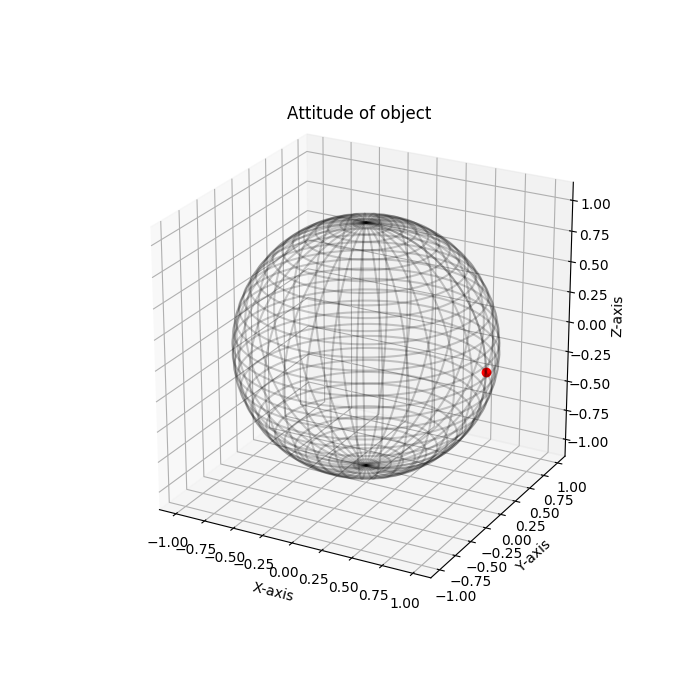

In [31]:
viz = Visualize()
viz.draw()

### Kinematics
We will discuss the derivation of the quaternion kinematics as described by Shuster in 'A Survey of Attitude Representations'.

The kinematics can be shown as


\begin{align}
q(t+\Delta t) &= \delta q(t)\otimes q(t) \\
&=\{\delta q(t)\}_Lq(t)
\end{align}

where $\delta q(t)$ describes a small rotation and $\{q\}_L$ is the matrix form of the quaternion. 

\begin{align}
\{q\}_L &= 
\begin{bmatrix}
 w & z &-y &x \\
-z & w & x &y \\
 y &-x & w &z \\
-x &-y &-z &w
\end{bmatrix}
\end{align}

Using Taylor Series expansion, $\delta q(t)$ can be expressed as

\begin{align}
\delta q(t) &= \begin{bmatrix} \Delta\xi(t)/2 \\ 1 \end{bmatrix} + O(|\Delta\xi(t)|^2)
\end{align}

where $O(|\Delta\xi(t)|^2)$ represent the higher order terms. The above expression can be expressed in matrix form

\begin{align}
\{\delta q(t)\}_L &= I_{4x4} + \frac{1}{2}\Omega_L(\Delta\xi(t)) + O(|\Delta\xi(t)|^2)
\end{align}

where 

\begin{align}
\Omega_L(v) &= 
\begin{bmatrix}
0 &v_3 &-v_2 &v_1 \\
-v_3 &0 &v_1 &v_2 \\
v_2 &-v_1 &0 &v_3 \\
-v_1 &-v_2 &-v_3 &0
\end{bmatrix}
\end{align}

Assuming that $\delta q(t)$ is very small, we can ignore the higher order terms, and the first equations can be expressed as.

\begin{align}
q(t+\Delta t) &= \delta q(t)\otimes q(t) \\
q(t+\Delta t) &= (I_{4x4} + \frac{1}{2}\Omega_L(\Delta\xi(t))) q(t) \\
q(t+\Delta t) &= I_{4x4} q(t) + \frac{1}{2}\Omega_L(\Delta\xi(t)) q(t) \\
q(t+\Delta t) - I_{4x4} q(t) &= \frac{1}{2}\Omega_L(\Delta\xi(t)) q(t) \\
\frac{1}{\Delta t}(q(t+\Delta t) - I_{4x4} q(t)) &= \frac{1}{\Delta t}(\frac{1}{2}\Omega_L(\Delta\xi(t))q(t)) \\
\frac{d}{dt}q(t) &= \frac{1}{2}\Omega_L(\omega)q(1) = \frac{1}{2}w\otimes q(t)
\end{align}
